In [2]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 15.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 18.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [4]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import timedelta
import numpy as np

In [2]:
file_path = "crisisnlp_combined_dataset.csv"  
df = pd.read_csv(file_path, parse_dates=['disaster_start_date', 'disaster_end_date', 'tweet_time_utc'])

# Ensure class_label is string
df['class_label'] = df['class_label'].astype(str)

In [3]:
df.head()

,tweet_id,tweet_text,class_label,split,disaster_name,country,location_region,disaster_start_date,disaster_end_date,year,tweet_time_utc
0,735891446960623616,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,other_relevant_information,train,canada_wildfires_2016,Canada,Alberta,2016-05-01 00:00:00+00:00,2016-05-31 23:59:59+00:00,2016,2016-05-26 17:52:47.814000+00:00
1,731202020296818688,Red Cross distributes $30M to Fort McMurray wi...,displaced_people_and_evacuations,train,canada_wildfires_2016,Canada,Alberta,2016-05-01 00:00:00+00:00,2016-05-31 23:59:59+00:00,2016,2016-05-13 19:18:41.372000+00:00
2,733665357236342784,Interesting insights on the shifting communica...,other_relevant_information,train,canada_wildfires_2016,Canada,Alberta,2016-05-01 00:00:00+00:00,2016-05-31 23:59:59+00:00,2016,2016-05-20 14:27:06.665000+00:00
3,731963038429929472,RT @globeandmail: Oil sands producers helping ...,rescue_volunteering_or_donation_effort,train,canada_wildfires_2016,Canada,Alberta,2016-05-01 00:00:00+00:00,2016-05-31 23:59:59+00:00,2016,2016-05-15 21:42:42.234000+00:00
4,728674838034944001,Ottawa to match Red Cross donations for Fort M...,rescue_volunteering_or_donation_effort,train,canada_wildfires_2016,Canada,Alberta,2016-05-01 00:00:00+00:00,2016-05-31 23:59:59+00:00,2016,2016-05-06 19:56:34.168000+00:00


In [5]:
df["tweet_time_utc"] = pd.to_datetime(
    df["tweet_time_utc"],
    format="mixed",
    utc=True,
    errors="coerce"
)

df["disaster_start_date"] = pd.to_datetime(
    df["disaster_start_date"],
    format="mixed",
    utc=True,
    errors="coerce"
)

# Days relative to disaster onset
df["days_since_disaster"] = (
    df["tweet_time_utc"] - df["disaster_start_date"]
).dt.days

In [6]:
df_just_after = df[(df["days_since_disaster"] >= 0) & (df["days_since_disaster"] <= 1)]
df_later = df[(df["days_since_disaster"] >= 2) & (df["days_since_disaster"] <= 7)]

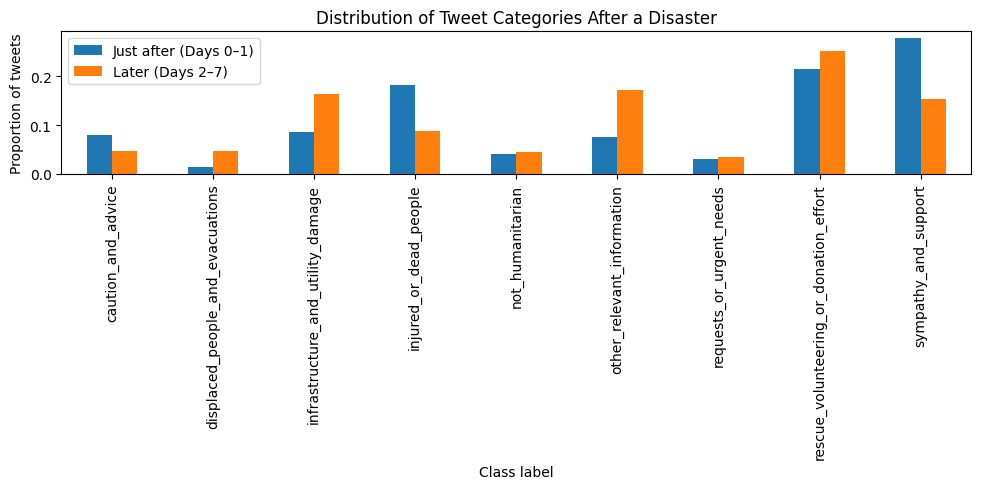

In [7]:
just_counts = df_just_after["class_label"].value_counts(normalize=True)
later_counts = df_later["class_label"].value_counts(normalize=True)

bar_df = pd.DataFrame({
    "Just after (Days 0–1)": just_counts,
    "Later (Days 2–7)": later_counts
}).fillna(0)

bar_df.sort_index().plot(
    kind="bar",
    figsize=(10,5)
)

plt.ylabel("Proportion of tweets")
plt.xlabel("Class label")
plt.title("Distribution of Tweet Categories After a Disaster")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from wordcloud import STOPWORDS

place_terms = set()

for name in df["disaster_name"].unique():
    place_terms |= set(name.replace("_", " ").split())

manual_places = {
    "ecuador", "mexico", "italy", "new", "zealand", "canada",
    "puerto", "rico", "caribbean", "florida", "bahamas",
    "sri", "lanka", "alberta", "wellington"
}
custom_stopwords = STOPWORDS | place_terms | manual_places | {
     "haiti","eqnz"
}

In [36]:
import re
from wordcloud import WordCloud

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in custom_stopwords and len(w) > 2]
    return " ".join(words)

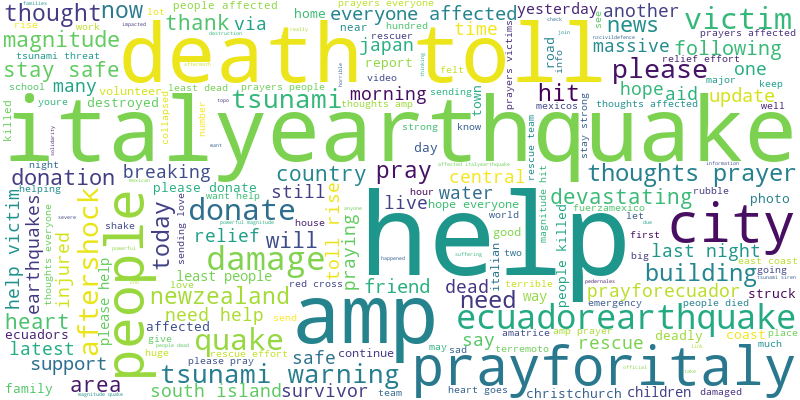

In [37]:
just_after_text = " ".join(
    df_just_after["tweet_text"]
    .dropna()
    .map(clean_text)
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
)

wc.generate(just_after_text).to_image()

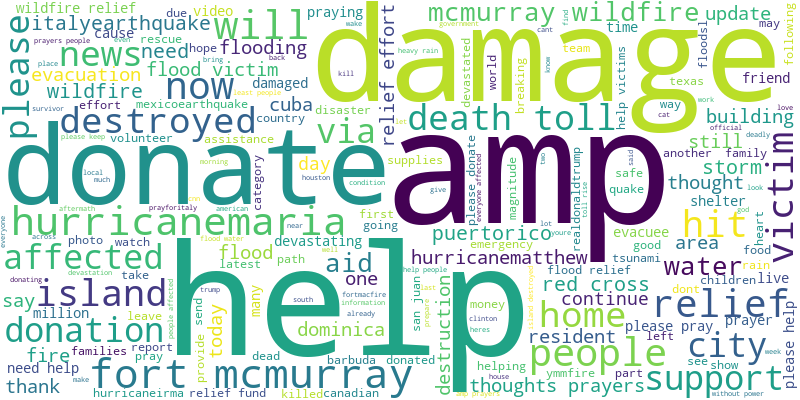

In [38]:
later_text = " ".join(
    df_later["tweet_text"]
    .dropna()
    .map(clean_text)
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
)

wc.generate(later_text).to_image()

In [39]:
focus_labels = [
    "injured_or_dead_people",
    "rescue_volunteering_or_donation_effort",
    "sympathy_and_support",
    "infrastructure_and_utility_damage"
]

In [40]:
def wordcloud_for_label(data, label, title):
    text = " ".join(
        data[data["class_label"] == label]["tweet_text"]
        .dropna()
        .map(clean_text)
    )
    if len(text.strip()) == 0:
        return None

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=150
    )
    return wc.generate(text).to_image()

In [41]:
import matplotlib.pyplot as plt

def plot_label_wordclouds(df_just, df_late, label):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for ax, data, title in zip(
        axes,
        [df_just, df_late],
        ["Just after (Days 0–1)", "Later (Days 2–7)"]
    ):
        text = " ".join(
            data[data["class_label"] == label]["tweet_text"]
            .dropna()
            .map(clean_text)
        )

        if len(text.strip()) == 0:
            ax.axis("off")
            ax.set_title(f"{title}\n(No data)")
            continue

        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=150
        ).generate(text)

        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(title, fontsize=12)

    fig.suptitle(f"Class label:\n{label}", fontsize=14)
    plt.tight_layout()
    plt.show()

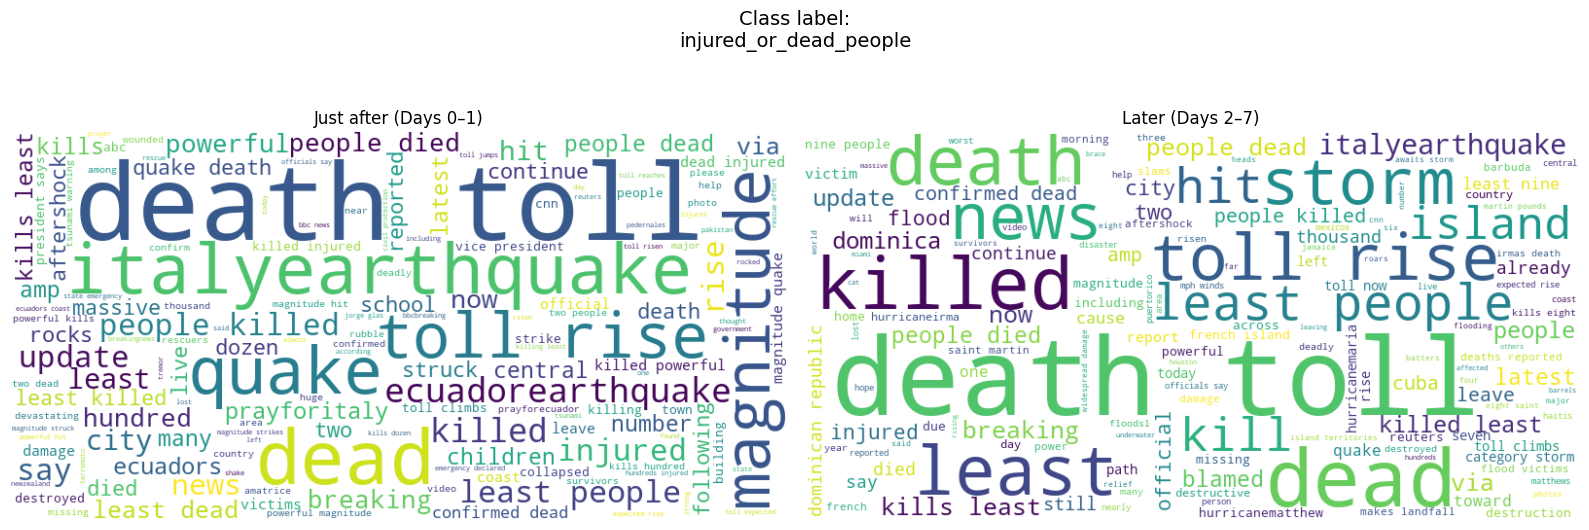

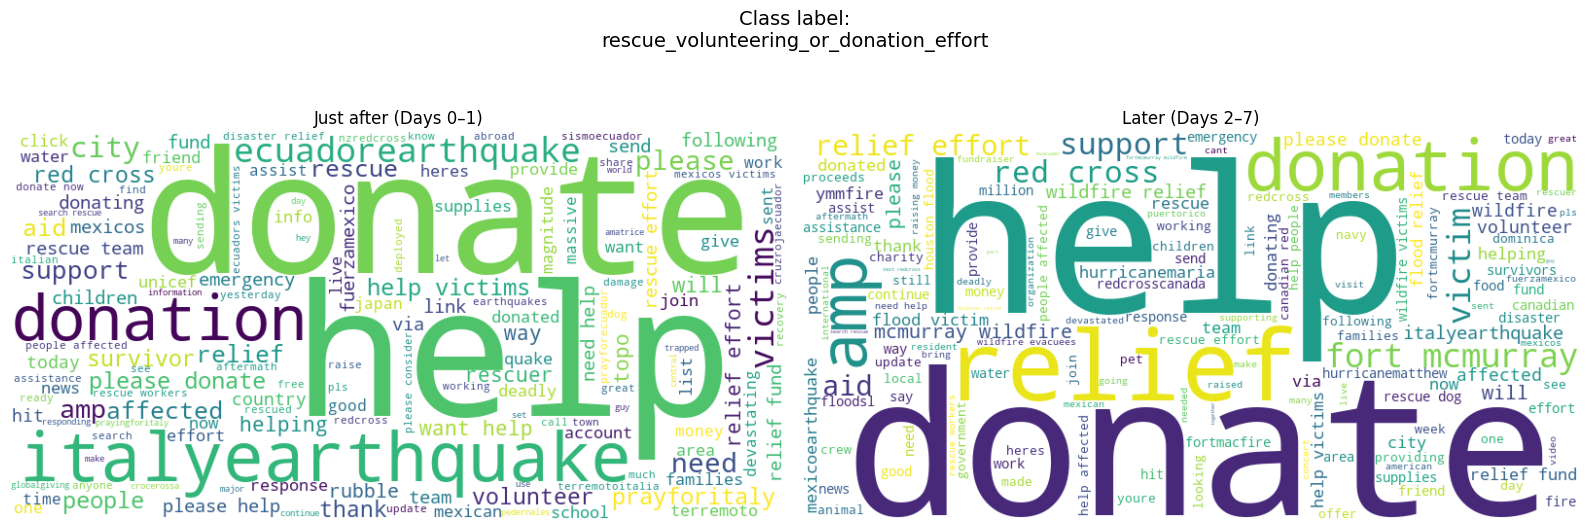

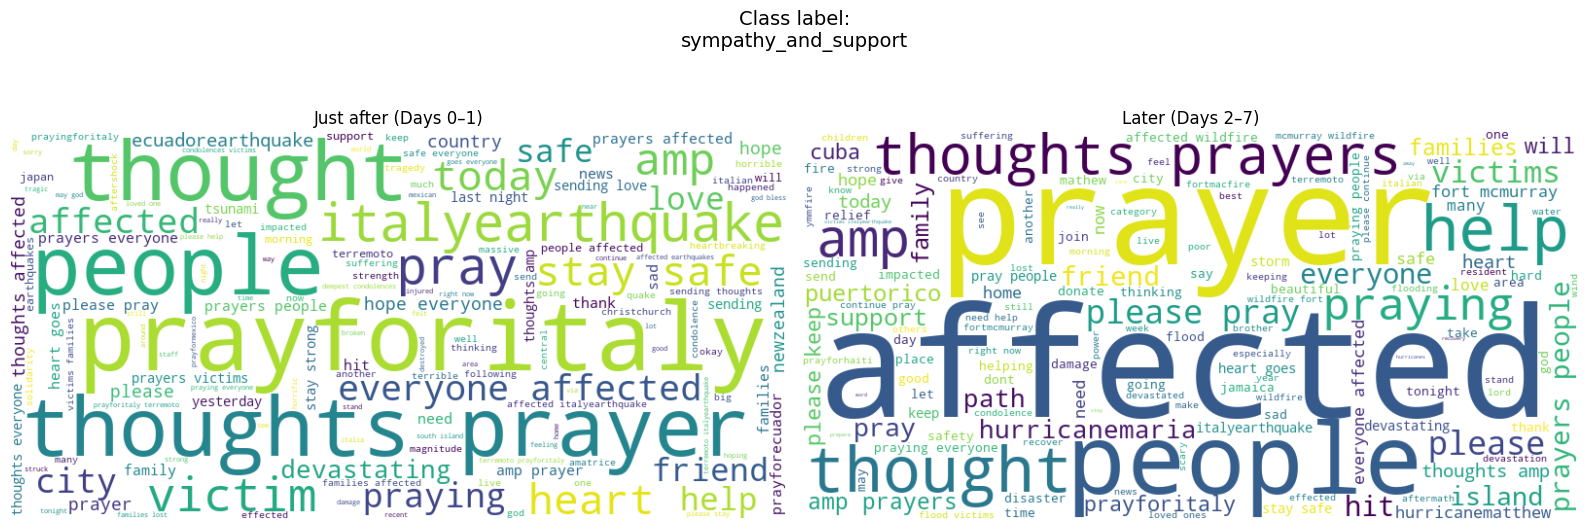

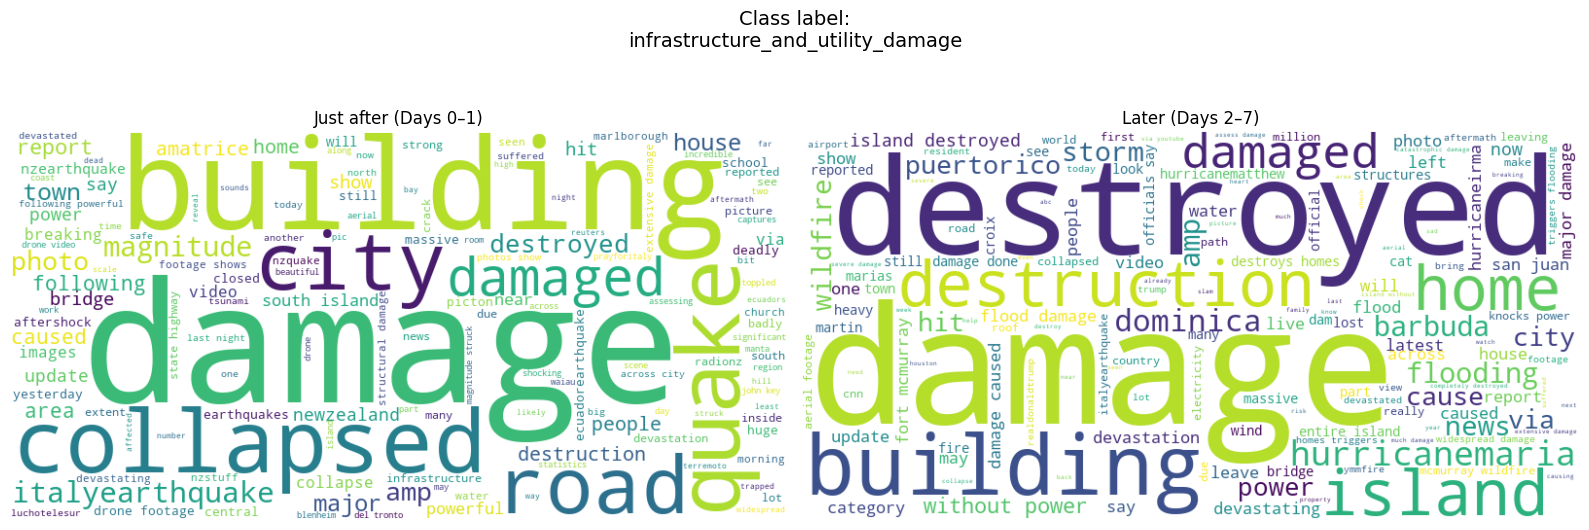

In [42]:
for label in focus_labels:
    plot_label_wordclouds(df_just_after, df_later, label)

In [43]:
from collections import Counter

def top_words(texts, n=50):
    tokens = " ".join(texts).split()
    return set([w for w, _ in Counter(tokens).most_common(n)])

In [44]:
for label in focus_labels:
    words_early = top_words(
        df_just_after[df_just_after["class_label"] == label]["tweet_text"]
        .dropna().map(clean_text)
    )
    words_late = top_words(
        df_later[df_later["class_label"] == label]["tweet_text"]
        .dropna().map(clean_text)
    )

    jaccard = len(words_early & words_late) / max(1, len(words_early | words_late))
    print(label, "Jaccard similarity:", round(jaccard, 2))

injured_or_dead_people Jaccard similarity: 0.35
rescue_volunteering_or_donation_effort Jaccard similarity: 0.43
sympathy_and_support Jaccard similarity: 0.47
infrastructure_and_utility_damage Jaccard similarity: 0.25


In [45]:
AGREEMENT_LABELS = {
    "rescue_volunteering_or_donation_effort",
    "sympathy_and_support",
    "infrastructure_and_utility_damage",
    "injured_or_dead_people"
}

DISAGREEMENT_LABELS = {
    "criticism",
    "irrelevant_or_negative",
    "other_relevant_information"
}

df["behavior_state"] = df["class_label"].apply(
    lambda x: "AGREE" if x in AGREEMENT_LABELS else "DISAGREE"
)

In [46]:
# Time of day
df["hour"] = df["tweet_time_utc"].dt.hour
df["time_bin"] = pd.cut(
    df["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["night", "morning", "afternoon", "evening"],
    right=False
)

# Event intensity proxy (log-scaled)
df["event_spike"] = np.log1p(
    df.groupby("disaster_name")["tweet_id"].transform("count")
)

# Region encoding
df["region_code"] = df["location_region"].astype("category").cat.codes

In [47]:
df = df.sort_values(["disaster_name", "tweet_time_utc"])

df["timestep"] = (
    df.groupby("disaster_name")["tweet_time_utc"]
      .transform(lambda x: (x - x.min()).dt.days)
)

In [48]:
from collections import Counter

def estimate_transition_matrix(subdf):
    transitions = Counter()
    totals = Counter()

    states = subdf["behavior_state"].values

    for i in range(len(states) - 1):
        transitions[(states[i], states[i+1])] += 1
        totals[states[i]] += 1

    matrix = {}
    for s1 in ["AGREE", "DISAGREE"]:
        for s2 in ["AGREE", "DISAGREE"]:
            matrix[(s1, s2)] = (
                transitions[(s1, s2)] / totals[s1]
                if totals[s1] > 0 else 0
            )
    return matrix

In [49]:
global_transition_matrix = estimate_transition_matrix(df)
print(global_transition_matrix)

{('AGREE', 'AGREE'): 0.6742575780889367, ('AGREE', 'DISAGREE'): 0.32574242191106323, ('DISAGREE', 'AGREE'): 0.5587594853183768, ('DISAGREE', 'DISAGREE'): 0.44124051468162323}


In [53]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 3.8 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 5.7 MB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [60]:
jaccard_map = {
    "injured_or_dead_people": 0.35,
    "rescue_volunteering_or_donation_effort": 0.43,
    "sympathy_and_support": 0.47,
    "infrastructure_and_utility_damage": 0.25
}

df["semantic_stability"] = (
    df["class_label"].map(jaccard_map).fillna(0.3)
)

In [62]:
from sklearn.linear_model import LogisticRegression

df["next_state"] = (
    df.groupby("disaster_name")["behavior_state"]
      .shift(-1)
)

model_df = df.dropna(subset=["next_state"])

X = model_df[
    ["days_since_disaster", "event_spike", "region_code"]
]
X = pd.get_dummies(
    pd.concat([X, model_df["time_bin"]], axis=1),
    drop_first=True
)

y = (model_df["next_state"] == "AGREE").astype(int)

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

/Users/debarpita/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/debarpita/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/debarpita/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [63]:
import random

def simulate_trajectory(
    start_state="DISAGREE",
    days=14,
    context_row=None,
    model=clf
):
    state = start_state
    trajectory = [state]

    for t in range(days):
        X_sim = context_row.copy()
        X_sim["days_since_disaster"] = t

        p_agree = model.predict_proba(X_sim)[0][1]
        state = "AGREE" if random.random() < p_agree else "DISAGREE"
        trajectory.append(state)

    return trajectory

In [64]:
context = X.iloc[[0]]  # representative context
simulations = [
    simulate_trajectory(context_row=context)
    for _ in range(1000)
]

In [65]:
final_states = [traj[-1] for traj in simulations]

pd.Series(final_states).value_counts(normalize=True)

AGREE       0.705
DISAGREE    0.295
Name: proportion, dtype: float64

In [66]:
X["semantic_stability"] = model_df["semantic_stability"]
clf.fit(X, y)

/Users/debarpita/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/debarpita/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/debarpita/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [67]:
print(model_df.columns)

Index(['tweet_id', 'tweet_text', 'class_label', 'split', 'disaster_name',
       'country', 'location_region', 'disaster_start_date',
       'disaster_end_date', 'year', 'tweet_time_utc', 'days_since_disaster',
       'behavior_state', 'hour', 'time_bin', 'event_spike', 'region_code',
       'timestep', 'next_state', 'semantic_stability'],
      dtype='object')
